In [23]:
import pandas as pd 
import numpy as np 
import re
from tqdm import tqdm 

In [2]:
import torch
import transformers
from transformers import BertForSequenceClassification, XLMRobertaForSequenceClassification, AdamW, BertConfig, BertTokenizer, XLMRobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import re
from bs4 import BeautifulSoup

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/option-generation/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [4]:
'''
Construct object in BERT sentiment classifier class
'''
sentiment_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden states.
)

sentiment_model.to(device) # Puts model on GPU

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [5]:
'''
Load pretrained sentiment model parameters
'''
sentiment_model.load_state_dict(torch.load("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/Testing/OptionGeneration/Model/English_sentiment_model.pt", map_location=device), strict=False)


_IncompatibleKeys(missing_keys=['bert.embeddings.position_ids'], unexpected_keys=[])

In [6]:
sentiment_model.eval() # Put model in inference (as opposed to training) mode

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [7]:
'''
Load tokenizer for sentiment model
'''
sentiment_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [8]:
# gets the text into the format we want
def clean_tweet(tweet):
  tweet = BeautifulSoup(tweet, "lxml").get_text() # turns xml-formatted text into regular text
  tweet = re.sub(r"@[A-Za-z0-9]+", " ", tweet) # gets rid of all user references in tweets (i.e. "@username")
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", " ", tweet) # gets rid of URLs
  tweet = re.sub(r"[^A-Za-z.!?áéíóúüñ¿ÁÉÍÓÚÜÑ']", " ", tweet) # gets rid of any non-standard characters in the tweets
  tweet = re.sub(r" +", " ", tweet) # replaces all excess whitespace with a single space

  return tweet # gives us our cleaned tweet

In [9]:
def predict_sentiment(tweet):

    '''
    Predict the sentiment of an input text
    '''
    
    tweet = clean_tweet(tweet)
    tweet_input_id = []
    tweet_attention_mask = []

    tweet_dict = sentiment_tokenizer.encode_plus(
                            tweet,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            truncation=True,           # Explicitly enable truncation
                            padding = 'max_length',
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

    # Add the encoded sentence to the list.    
    tweet_input_id.append(tweet_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    tweet_attention_mask.append(tweet_dict['attention_mask'])

    # Convert the lists into tensors.
    tweet_input_id = torch.cat(tweet_input_id, dim=0)
    tweet_attention_mask = torch.cat(tweet_attention_mask, dim=0)

    tweet_data = TensorDataset(tweet_input_id, tweet_attention_mask)
    
    tweet_dataloader = DataLoader(tweet_data)
    
    for data in tweet_dataloader:
        tweet_input_id = data[0].to(device=device)
        tweet_attention_mask = data[1].to(device=device)
    
    tweet_logits = sentiment_model(tweet_input_id, token_type_ids=None, attention_mask=tweet_attention_mask)
    
    tweet_logits = tweet_logits[0].detach().cpu().numpy()

    tweet_logits = torch.Tensor(tweet_logits)

    softmax = torch.nn.Softmax(dim=1)
    prob_dist = softmax(tweet_logits)

    sentiment_pred = prob_dist.tolist()

    sentiment_pred = sentiment_pred[0][1]

    return sentiment_pred

In [15]:
#Another version of semantic distance here 
from transformers import pipeline 

In [16]:
#sentence level embeddings 
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')
#example use 
# sentences = ["Hello World", "Hallo Welt"]
# embeddings = model.encode(sentences)
# print(embeddings)

In [17]:
generations = pd.read_csv('https://raw.githubusercontent.com/gokulsrin/PossibilityGeneration/main/TimeData/LDmodified.csv')

In [18]:
import math 
from scipy import spatial 
# def dist(r1, r2):
#   r1 = np.array(r1)
#   r2 = np.array(r2)
#   return np.linalg.norm((r1 - r2), ord=2)
def dist(r1, r2):
  r1 = np.array(r1)
  r2 = np.array(r2)
  return spatial.distance.cosine(r1, r2)
# def dist(r1, r2):
#   r1 = np.array(r1)
#   r2 = np.array(r2)
#   return np.linalg.norm((r1 - r2), ord=1)

# **Total Semantic Exploration (adjusted) vs Average Sentiment**

In [ ]:
#semantic exploration vs average sentiment
exploration = {}
individual_sentiment = {}
for id, group in generations.groupby("id"):
  exploration[id] = 0
  individual_sentiment[id] = []
  len_responses = 0
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    for response, group3 in group2.groupby("response"):
      if not pd.isna(response):
        embeddings.append(model.encode(response))
        individual_sentiment[id].append(predict_sentiment(response))
    len_responses += len(embeddings)
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        exploration[id] += dist(embeddings[i], embeddings[j])
  exploration[id] /= len_responses

In [ ]:
#find average sentiment 
for id in individual_sentiment:
  individual_sentiment[id] = sum(individual_sentiment[id])/len(individual_sentiment[id])

In [ ]:
x = []
y = []
for id in exploration:
  # if .7 < individual_sentiment[id] < .9:
    x.append(individual_sentiment[id])
    y.append(exploration[id])

In [ ]:
#display adjusted exploration vs average sentiment 
import seaborn as sns 
import scipy.stats as stats
import matplotlib.pyplot as plt

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Average Sentiment', ylabel='Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [ ]:
#try to combine the above two plots 
import plotnine
from plotnine import ggplot, aes
# package for plot scales
from mizani.formatters import comma_format # (thousands seperator format)

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Average_Sentiment", "Semantic_Exploration"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Average_Sentiment', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5) + 
 plotnine.xlab("Average Sentiment") +
 plotnine.ylab("Semantic Exploration") + 
 plotnine.coords.coord_cartesian(ylim=(2,3)) +
 plotnine.theme_classic()
).draw()




#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


In [ ]:
def average_embedding(embeddings):
  df = pd.DataFrame(embeddings)
  df = df.mean(axis=0)
  return df.values.tolist()

# **Total Semantic Exploration vs Generation Number**

In [ ]:
generations

In [ ]:
# Real semantic exploration 
#exploration and answers tally average
exploration = {}
answers = {}
#exp and nums tally the individual explorations
exp = []
nums = []
for id, group in generations.groupby("id"):
  for pnum, group2 in group.groupby("generation_number"):
    if pnum not in exploration: 
      exploration[pnum] = []
      # answers[pnum] = 0
    embeddings = []
    for response, group3 in group2.groupby("response"):
      response = group3['response'].to_list()[0]
      if not pd.isna(response):
        embeddings.append(model.encode(response).tolist())
    # answers[pnum] += len(embeddings)
    e = 0
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        # exploration[pnum] = dist_fn(embeddings[i], embeddings[j]) + exploration.get(pnum)
        e += dist(embeddings[i], embeddings[j])
    exploration[pnum].append(e/len(embeddings))
    exp.append(e/len(embeddings))
    nums.append(pnum)

x_avg = []
y_avg = []
for num in exploration:
  x_avg.append(num)
  y_avg.append(sum(exploration[num])/len(exploration[num]))

In [ ]:
#plotting for stats
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[nums,exp])
d = d.T
d.columns = ["Generation_Number", "Semantic_Exploration"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Semantic_Exploration"]

In [ ]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Semantic_Exploration"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Semantic_Exploration-yerr",ymax="Semantic_Exploration+yerr"), color="red",width=.15) + 
 plotnine.ylab("Semantic Exploration") +
 plotnine.xlab("Generation Number") +
  plotnine.coords.coord_cartesian(ylim=(5,5.70)) +
 plotnine.theme_classic()
  ).draw()

In [ ]:
def total_variation(e):
  variation = 0
  count = 0
  for i in range(len(e)):
    for j in range(i+1, len(e)):
      variation += dist(e[i], e[j])
      count += 1
      if count%10000==0:
        print("done")
  return variation

# **Semantic Dissimilarity vs Generation Number**

In [ ]:
# Semantic space similarity vs possibiltiy number (pairwise sim between all avg. embedding vectors)
vectordic = {}
for id, group in generations.groupby("id"):
  for pnum, group2 in group.groupby("generation_number"):
    if pnum not in vectordic:
      vectordic[pnum] = []
    embeddings = []
    for generation in group2['response']:
      if not pd.isna(generation):
        embeddings.append(model.encode(generation))
    embeddings = pd.DataFrame(embeddings)
    embeddings = embeddings.mean(axis=0)
    embeddings = embeddings.values.tolist()
    vectordic.get(pnum).append(embeddings)


In [ ]:
#semantic space dissimilarity vs generation nums
similarity = []
nums = []
avg_dic = {}
for num in vectordic:
  avg_dic[num] = []
  for i in range(len(vectordic.get(num))):
    for j in range(i+1, len(vectordic.get(num))):
      nums.append(num)
      s = dist(vectordic.get(num)[i], vectordic.get(num)[j])
      similarity.append(s)
      avg_dic[num].append(s)


In [ ]:
# remove invalid data - why would the distance between two distinct localizing vectors be 0? 
x = nums
y = similarity
i = 0 
avg_dic = {}
while i < len(x):
  if y[i] == 0:
    y.pop(i)
    x.pop(i)
    i -= 1
  else:
    if x[i] not in avg_dic:
      avg_dic[x[i]] = []
    avg_dic[x[i]].append(y[i])
  i += 1
x_avg = []
y_avg = []
for num in avg_dic:
  avg_dic[num] = sum(avg_dic[num])/len(avg_dic[num])
  x_avg.append(num)
  y_avg.append(avg_dic[num])

In [ ]:
#plotting to find stats 
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

In [ ]:
#plotting to find stats 

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Semantic_Dissimilarity"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Semantic_Dissimilarity"]

In [ ]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Semantic_Dissimilarity"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Semantic_Dissimilarity'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.1) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Semantic_Dissimilarity-yerr",ymax="Semantic_Dissimilarity+yerr"), color="red",width=.15) + 
 plotnine.ylab("Semantic Dissimilarity") +
 plotnine.xlab("Generation Number") +
  plotnine.coords.coord_cartesian(ylim=(.4,.5)) +
 plotnine.theme_classic()
  ).draw()

In [ ]:
generations

# **Subjective Goodness vs Generation Number**

In [ ]:
#average goodness rating per possibility 
scores = [[] for i in range(8)]
nums = [i for i in range(8)]

#all of the ratings 
s = []
n = []

for pnum, group1 in generations.groupby("generation_number"):
  print(len(group1))
  for score in group1['reflection_score']:
    scores[pnum-1].append(score)
    s.append(score)
    n.append(pnum)

for i in range(len(scores)):
  scores[i] = sum(scores[i])/len(scores[i])

In [ ]:
#plotting for stats
x_avg = np.array(nums) 
y_avg = np.array(scores)

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Subjective Rationality', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[n,s])
d = d.T
d.columns = ["Generation_Number", "Generation_Goodness"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Goodness"]

errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Goodness"]/(len(group["Generation_Goodness"])**.5))
d2["yerr"] = errors


In [ ]:
scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Generation_Goodness'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Goodness-yerr",ymax="Generation_Goodness+yerr"), color="red",width=.15) + 
 plotnine.ylab("Subjective Rationality") +
 plotnine.xlab("Generation Number") + 
 plotnine.theme_classic()  +
 plotnine.coords.coord_cartesian(ylim=(35,80)) 
 ).draw()

# **Generation Sentiment vs Generation Number**

In [ ]:
#generation sentiment vs generation number

sentiment = []
nums = []
avg_sentiment = {}
for id, participant in generations.groupby('id'):
  for pos_num, group in participant.groupby('generation_number'):
    if pos_num not in avg_sentiment:
      avg_sentiment[pos_num] = []
    for generation in group['response']:
      if not pd.isna(generation):
        s = predict_sentiment(generation)
        sentiment.append(s)
        nums.append(pos_num)
        avg_sentiment[pos_num].append(s)

In [ ]:
x = nums
y = sentiment

x_avg = []
y_avg = []
for num in avg_sentiment:
  x_avg.append(num)
  y_avg.append(sum(avg_sentiment[num])/len(avg_sentiment[num]))

In [ ]:
#plotting for stats 
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Sentiment', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Generation_Sentiment"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Sentiment"]

errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Sentiment"]/(len(group["Generation_Sentiment"])**.5))
d2["yerr"] = errors


In [ ]:
scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Generation_Sentiment'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Sentiment-yerr",ymax="Generation_Sentiment+yerr"), color="red",width=.15) + 
 plotnine.ylab("Generation Sentiment") +
 plotnine.xlab("Generation Number") + 
 plotnine.theme_classic() +
 plotnine.coords.coord_cartesian(ylim=(.55,.65)) 
).draw()

# **Generation Concreteness vs Generation Number**

In [ ]:
concreteness = pd.read_csv("https://raw.githubusercontent.com/gokulsrin/PossibilityGeneration/main/Misc/Concreteness_ratings_Brysbaert_et_al_BRM.csv")

In [ ]:
#create concreteness dict
concreteness_dict = {}
for word, group in concreteness.groupby("Word"):
  rating = group["Conc.M"].values[0]
  concreteness_dict[word] = rating

In [ ]:
#figure out if later generations are more or less concrete 
import string 

conc = []
nums = []
cdic = {}
for id, group in generations.groupby("id"):
  for vign, group2 in group.groupby("vignette_name"):
    for num, group3 in group2.groupby("generation_number"):
      for response, group4 in group3.groupby("response"):
        if not pd.isna(response):
          response = response.translate(str.maketrans('', '', string.punctuation))
          score = []
          l = len(response.split(" "))
          for word in response.split(" "):
            if word in concreteness_dict:
              score.append(concreteness_dict[word])
          if len(score) > 0:
            score = sum(score)/len(score)
            # score = (sum(score)/len(score))/l
            conc.append(score)
            nums.append(num)
            if num not in cdic:
              cdic[num] = []
            cdic[num].append(score)

In [ ]:
#find averages in concreteness differences
x_avg = []
y_avg = [] 
for key in cdic:
  cdic[key] = sum(cdic[key])/len(cdic[key])
  x_avg.append(key)
  y_avg.append(cdic[key])

print(cdic)

In [ ]:
#just for stats

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Generation Concreteness', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[nums,conc])
d = d.T
d.columns = ["Generation_Number", "Generation_Concreteness"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Concreteness"]

In [ ]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Concreteness"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d2, mapping=aes(x='Generation_Number', y='Generation_Concreteness', ymin=2.7))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.2) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.70, color="red", se=False) + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Concreteness-yerr",ymax="Generation_Concreteness+yerr"), color="red",width=.15) + 
 plotnine.ylab("Generation Concreteness") +
 plotnine.xlab("Generation Number") + 
  plotnine.coords.coord_cartesian(ylim=(2.6,2.9))
  ).draw()

# **Concreteness vs Semantic Relatedness**

In [ ]:
#bin the generations based on concreteness 
gens = {}
for response, group in generations.groupby("response"):
    response = response.translate(str.maketrans('', '', string.punctuation))
    score = []
    l = len(response.split(" "))
    for word in response.split(" "):
      if word in concreteness_dict:
        score.append(concreteness_dict[word])
    if len(score) > 0:
      score = sum(score)/len(score)
      gens[response] = score

In [ ]:
#bin all of the responses : num bins = 10 
gens = dict(sorted(gens.items(), key=lambda item: item[1]))
len(gens)

In [ ]:
nbins = 100
bins = [[] for j in range(nbins)]
i = 0 
for item in gens:
  if i//int(len(gens)/nbins) < nbins:
    bins[i//int(len(gens)/nbins)].append((item, gens[item]))
  i += 1

In [ ]:
from tqdm import tqdm

In [ ]:
similarity = {}
for b in tqdm(range(len(bins))):
  if b not in similarity: 
    similarity[b] = []
  bin = bins[b]
  embeddings = {}
  for response in bin:
    response = response[0]
    embeddings[response] = model.encode(response)
  for i in range(len(bin)):
    for j in range(i+1, len(bin)):
      similarity[b].append(dist(embeddings[bin[i][0]], embeddings[bin[j][0]]))
  print(b)
similarity 


In [ ]:
buckets = {}
for key in similarity:
  buckets[key] = sum(similarity[key])/len(similarity[key])

In [ ]:
x_avg = []
y_avg = []

for key in buckets:
  x_avg.append(key)
  y_avg.append(buckets[key])

In [ ]:
# to be clear, higher buckets have higher concreteness. 

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Concreteness Bucket', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[x_avg,y_avg])
d = d.T
d.columns = ["Concreteness_Bucket", "Semantic_Dissimilarity"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Concreteness_Bucket', y='Semantic_Dissimilarity'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Concreteness Bucket") +
 plotnine.ylab("Semantic Dissimilarity") + 
 plotnine.theme_classic()
).draw()

#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


In [ ]:
#replication of this experiment with a third model
#################################### 
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [ ]:
#bin the generations based on concreteness 
gens = {}
for response, group in generations.groupby("response"):
    response = response.translate(str.maketrans('', '', string.punctuation))
    score = []
    l = len(response.split(" "))
    for word in response.split(" "):
      if word in concreteness_dict:
        score.append(concreteness_dict[word])
    if len(score) > 0:
      score = sum(score)/len(score)
      gens[response] = score

In [ ]:
#bin all of the responses : num bins = 10 
gens = dict(sorted(gens.items(), key=lambda item: item[1]))
len(gens)

In [ ]:
nbins = 100
bins = [[] for j in range(nbins)]
i = 0 
for item in gens:
  if i//int(len(gens)/nbins) < nbins:
    bins[i//int(len(gens)/nbins)].append((item, gens[item]))
  i += 1

In [ ]:
from tqdm import tqdm

In [ ]:
similarity = {}
for b in tqdm(range(len(bins))):
  if b not in similarity: 
    similarity[b] = []
  bin = bins[b]
  embeddings = {}
  for response in bin:
    response = response[0]
    embeddings[response] = model.encode(response)
  for i in range(len(bin)):
    for j in range(i+1, len(bin)):
      similarity[b].append(dist(embeddings[bin[i][0]], embeddings[bin[j][0]]))
  print(b)
similarity 


In [ ]:
buckets = {}
for key in similarity:
  buckets[key] = sum(similarity[key])/len(similarity[key])

In [ ]:
x_avg = []
y_avg = []

for key in buckets:
  x_avg.append(key)
  y_avg.append(buckets[key])

In [ ]:
# to be clear, higher buckets have higher concreteness. 

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Concreteness Bucket', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

# **Semantic Exploration vs Average Concreteness**

In [ ]:
# semantic exploration 
exploration = {}
for id, group in generations.groupby("id"):
  exploration[id] = 0
  len_responses = 0
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    for response, group3 in group2.groupby("response"):
      if not pd.isna(response):
        embeddings.append(model.encode(response))
    len_responses += len(embeddings)
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        exploration[id] += dist(embeddings[i], embeddings[j])
  exploration[id] /= len_responses

In [ ]:
#determine avg concreteness 
id_concreteness = {}
for id, group in generations.groupby("id"):
  for response, group2 in group.groupby("response"):
    response = response.translate(str.maketrans('', '', string.punctuation))
    score = []
    l = len(response.split(" "))
    for word in response.split(" "):
      if word in concreteness_dict:
        score.append(concreteness_dict[word])
    if len(score) > 0:
      if id not in id_concreteness:
        id_concreteness[id] = []
      score = sum(score)/len(score)
      id_concreteness[id].append(score)

In [ ]:
for id in id_concreteness:
  id_concreteness[id] = sum(id_concreteness[id])/len(id_concreteness[id])

In [ ]:
x = []
y = []
for id in id_concreteness:
  if id in exploration:
    x.append(id_concreteness[id])
    y.append(exploration[id])

In [ ]:
#display adjusted exploration vs average sentiment 
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Average Concreteness', ylabel='Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Average_Concreteness", "Semantic_Exploration"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Average_Concreteness', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Average Concreteness") +
 plotnine.ylab("Semantic Exploration") + 
 plotnine.theme_classic() + 
 plotnine.coords.coord_cartesian(ylim=(2,3.5))
).draw()

#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


# **Generation Concreteness vs Subjective Score**

In [ ]:
concreteness = []
subjective = []
for response, group in generations.groupby("response"):
  response = response.translate(str.maketrans('', '', string.punctuation))
  score = []
  l = len(response.split(" "))
  for word in response.split(" "):
    if word in concreteness_dict:
      score.append(concreteness_dict[word])
  if len(score) > 0 :
    score = sum(score)/len(score)
    concreteness.append(score)
    subjective.append(list(group["reflection_score"])[0])


In [ ]:
x = concreteness
y = subjective

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Concreteness', ylabel='Subjective Score', size=12)
plt.tight_layout()
plt.show()

# **Generation Concreteness vs Generation Sentiment**

In [ ]:
concreteness = []
sentiment = []
for response, group in generations.groupby("response"):
  response = response.translate(str.maketrans('', '', string.punctuation))
  score = []
  l = len(response.split(" "))
  for word in response.split(" "):
    if word in concreteness_dict:
      score.append(concreteness_dict[word])
  if len(score) > 0:
    score = sum(score)/len(score)
    concreteness.append(score)
    sentiment.append(predict_sentiment(response))


In [ ]:
x = concreteness
y = sentiment

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Concreteness', ylabel='Sentiment', size=12)
plt.tight_layout()
plt.show()

# **Timed Analysis**
Results to develop here: 


1.   Total sematic exploration (adjusted) vs time
2.   Successive Semantic Distance vs time
3.  Time vs Distance from center of mass 
4.  Total time vs Generation Number
5. Generation Time v Concreteness 



# **Total Semantic Exploration (adjusted) vs Time**

In [ ]:
generations

In [ ]:
# total (adjusted) exploration vs total generation time 
exploration = {}
times = {}
for id, group in generations.groupby("id"):
  exploration[id] = 0
  times[id] = 0
  len_responses = 0
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    for response, group3 in group2.groupby("response"):
      if not pd.isna(response):
        embeddings.append(model.encode(response))
        times[id] += list(group3["generation_time"])[0]
    len_responses += len(embeddings)
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        exploration[id] += dist(embeddings[i], embeddings[j])
  exploration[id] /= len_responses
  times[id] 

In [ ]:
x = []
y = []
for id in exploration:
  x.append(times[id])
  y.append(exploration[id])

In [ ]:
#just for stats

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Total Generation Time', ylabel='Total Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Semantic_Exploration"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.5) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Generation Number") +
 plotnine.ylab("Semantic Exploration") + 
 plotnine.coords.coord_cartesian(ylim=(2,3)) + 
 plotnine.theme_classic()
).draw()


# **Successive Semantic Distance vs Generation Time**

In [ ]:
distance = []
time = []

for id, group in generations.groupby("id"):
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    times = []
    for response, group3 in group2.groupby("response"):
      if not pd.isna(response):
        embeddings.append(model.encode(response))
        times.append(list(group3["generation_time"])[0])
    for i in range(len(embeddings)-1):
      j = i+1
      distance.append(dist(embeddings[i], embeddings[j]))
      time.append(times[j])


In [ ]:
#just for stats
x = np.array(time)
y = distance
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Time', ylabel='Successive Semantic Distance', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Successive_Semantic_Distance"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Successive_Semantic_Distance'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.5) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Generation Number") +
 plotnine.ylab("Successive Semantic Distance") + 
 plotnine.theme_classic()
).draw()


# **Distance from Center of Mass vs Time**

In [ ]:
def average_embedding(embeddings):
  df = pd.DataFrame(embeddings)
  df = df.mean(axis=0)
  return df.values.tolist()

In [ ]:
DCOM = []
time = []
for id,group in generations.groupby("id"):
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    responses = []
    times = []
    for num, group3 in group2.groupby("generation_number"):
      responses.append(list(group3["response"])[0])
      times.append(list(group3["generation_time"])[0])
    for row in zip(responses, times):
      response = row[0]
      gtime = row[1]
      if not pd.isna(response):
        if len(embeddings) > 0:
          current = model.encode(response)
          COM = average_embedding(embeddings)
          DCOM.append(dist(current, COM))
          time.append(gtime)
        embeddings.append(model.encode(response))

In [ ]:
x = np.array(time)
y = DCOM
#just for stats
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Time', ylabel='Distance from Center of Mass', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "DCOM"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='DCOM'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.5) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Generation Number") +
 plotnine.ylab("Distance from Center of Mass") + 
 plotnine.theme_classic()
).draw()


# **Total Time vs Generation Number**

In [ ]:
#Total time vs possibility number
time = []
nums = []
times = {}
for id, group in generations.groupby("id"):
  for pnum, group1 in group.groupby("generation_number"):
    if pnum not in times:
      times[pnum] = []
    for response, group2 in group1.groupby("response"):
      t = list(group2["generation_time"])[0]
      times[pnum].append(t)
      time.append(t)
      nums.append(pnum)

In [ ]:
x_avg = [i for i in range(8)]
y_avg = []
for num in times:
  y_avg.append(sum(times[num])/len(times[num]))

In [ ]:

#just for stats
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Total Time', size=12)
plt.tight_layout()
plt.show()

In [ ]:
nums = np.array(nums)
time = np.array(time)
d = pd.DataFrame(data=[nums,time])
d = d.T
d.columns = ["Generation_Number", "Generation_Time"]
y_avg = np.array(y_avg)
d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Time"]

In [ ]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Time"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d2, mapping=aes(x='Generation_Number', y='Generation_Time'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.4) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.70, color="red", se=False) + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Time-yerr",ymax="Generation_Time+yerr"), color="red",width=.15) + 
 plotnine.ylab("Generation Time") +
 plotnine.xlab("Generation Number") + 
  plotnine.coords.coord_cartesian(ylim=(5,25)) + 
 plotnine.theme_classic()
  ).draw()

# **Generation Concreteness vs Generation Time**

In [ ]:
gc = []
time = []

for response, group in generations.groupby("response"):
  response = response.translate(str.maketrans('', '', string.punctuation))
  score = []
  l = len(response.split(" "))
  for word in response.split(" "):
    if word in concreteness_dict:
      score.append(concreteness_dict[word])
  if len(score) > 0:
    score = sum(score)/len(score)
    gc.append(score)
    time.append(list(group["generation_time"])[0])

In [ ]:
x = np.array(time)/1000
y= gc
#just for stats
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Time (s)', ylabel='Generation Concreteness', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Time", "Generation_Concreteness"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Generation_Time', y='Generation_Concreteness'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.5) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Generation Time") +
 plotnine.ylab("Generation Concreteness") + 
 plotnine.theme_classic()
).draw()


# Heatmap Analysis 
* The goal here is twofold: 
1. Density map of generations per gen_num in 2D PCA space
    * Maybe make this like 100 by 100
2. Heatmap of average senitment per gen_num in 2D PCA space

Then, perhaps we can overlay these two figures.

## Density Map

In [20]:
generations

,Unnamed: 0,vignette_name,generation_number,generation_time,response,reflection_score,id
0,0,scenario4,1,3.668,sleep,1.000000,R_12rsaTqrSH1Qt91
1,1,scenario4,2,2.471,eat,1.000000,R_12rsaTqrSH1Qt91
2,2,scenario4,3,2.672,read,1.000000,R_12rsaTqrSH1Qt91
3,3,scenario4,4,5.778,watch a show,1.000000,R_12rsaTqrSH1Qt91
4,4,scenario4,5,4.766,talk to someone,1.000000,R_12rsaTqrSH1Qt91
...,...,...,...,...,...,...,...
3315,3315,scenario8,4,31.786,Tell a joke.,0.428571,R_xzxlgFF9Ss7DY7n
3316,3316,scenario8,5,15.107,Push the emergency stop,0.142857,R_xzxlgFF9Ss7DY7n
3317,3317,scenario8,6,25.589,"Take a video for social media showing your ""ne...",0.285714,R_xzxlgFF9Ss7DY7n
3318,3318,scenario8,7,34.393,Complain that you have to go to work/appointme...,0.428571,R_xzxlgFF9Ss7DY7n


In [21]:
generations["vignette_name"].unique()

array(['scenario4', 'scenario5', 'scenario6', 'scenario8', 'scenario3',
       'scenario7', 'scenario1', 'scenario2'], dtype=object)

In [120]:
#start witht just the first generation embeddings
names = set(['scenario5'])
embeddings = []
embed_map = {} #map index in embeddings to the pnum 
embed_weights = [] #keep the sentiment of embeddings[i]
responses = []
vigns = []
for pnum, group in tqdm(generations.groupby("generation_number")):
    for row in tqdm(list(zip(group["response"],group["vignette_name"]))):
        response = row[0]
        name = row[1]
        if not pd.isna(response) and name in names:
            embeddings.append(model.encode(response))
            responses.append(response)
            vigns.append(name)
            embed_map[len(embeddings)-1] = pnum
            embed_weights.append(predict_sentiment(response))

 37%|████████████████████████████████████████████████████████████▎                                                                                                       | 153/416 [00:00<00:00, 677.05it/s]/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/option-generation/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:00<00:00, 615.59it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.45it/s]


In [121]:
len(embeddings)

394

In [122]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import binned_statistic_2d
from sklearn.manifold import TSNE

In [123]:
embeddings = StandardScaler().fit_transform(embeddings)
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=10)

In [124]:
#get all of the embeddings for possibilities 1,2 and 3

embed_1 = []
embed_1_weights = []
embed_1_responses = []
for i in range(len(embeddings)):
    if embed_map[i] == 1:
        embed_1.append(embeddings[i])
        embed_1_weights.append(embed_weights[i])
        embed_1_responses.append(str(vigns[i] +": " +responses[i]))

        
embed_2 = []
embed_2_weights = []
embed_2_responses = []
for i in range(len(embeddings)):
    if embed_map[i] == 2:
        embed_2.append(embeddings[i])
        embed_2_weights.append(embed_weights[i])
        embed_2_responses.append(str(vigns[i] +": " +responses[i]))
        

embed_3 = []
embed_3_weights = []
embed_3_responses = []
for i in range(len(embeddings)):
    if embed_map[i] == 3:
        embed_3.append(embeddings[i])
        embed_3_weights.append(embed_weights[i])
        embed_3_responses.append(str(vigns[i] +": " +responses[i]))
        
embed_4 = []
embed_4_weights = []
embed_4_responses = []
for i in range(len(embeddings)):
    if embed_map[i] == 4:
        embed_4.append(embeddings[i])
        embed_4_weights.append(embed_weights[i])
        embed_4_responses.append(str(vigns[i] +": " +responses[i]))

embed_5 = []
embed_5_weights = []
embed_5_responses = []
for i in range(len(embeddings)):
    if embed_map[i] == 5:
        embed_5.append(embeddings[i])
        embed_5_weights.append(embed_weights[i])
        embed_5_responses.append(str(vigns[i] +": " +responses[i]))

embed_6 = []
embed_6_weights = []
embed_6_responses = []
for i in range(len(embeddings)):
    if embed_map[i] == 6:
        embed_6.append(embeddings[i])
        embed_6_weights.append(embed_weights[i])
        embed_6_responses.append(str(vigns[i] +": " +responses[i]))
        
embed_7 = []
embed_7_weights = []
embed_7_responses = []
for i in range(len(embeddings)):
    if embed_map[i] == 7:
        embed_7.append(embeddings[i])
        embed_7_weights.append(embed_weights[i])
        embed_7_responses.append(str(vigns[i] +": " +responses[i]))
        
embed_8 = []
embed_8_weights = []
embed_8_responses = []
for i in range(len(embeddings)):
    if embed_map[i] == 8:
        embed_8.append(embeddings[i])
        embed_8_weights.append(embed_weights[i])
        embed_8_responses.append(str(vigns[i] +": " +responses[i]))



In [125]:
print(len(embed_1), len(embed_8))

50 49


In [126]:
bin_size = 20

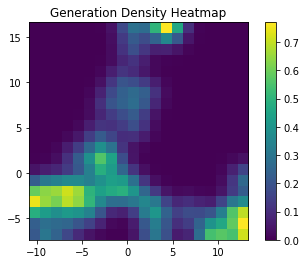

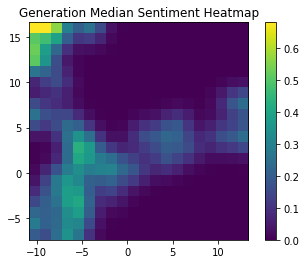

In [127]:
#scatterplot
principalComponents = pca.fit_transform(np.array(embed_1))
embed_1 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
embed_1["responses"] = embed_1_responses
fig = px.scatter(embed_1, x="pc1", y="pc2", opacity=.4, hover_name="responses")
fig.show()

#heatmap
heatmap1, xedges, yedges = np.histogram2d(list(embed_1["pc1"]), list(embed_1["pc2"]), bins=bin_size, density=False)
heatmap1 = gaussian_filter(heatmap1, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap1.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights as sentiment
# heatmap, xedges, yedges = np.histogram2d(list(embed_1["pc1"]), list(embed_1["pc2"]), bins=bin_size, weights = embed_1_weights, density=True)
# # average = heatmap / np.sum(heatmap)
# heatmap = gaussian_filter(heatmap, sigma=1)
# # print(heatmap)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()

#median sentiment heatmap

# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_1["pc1"]), list(embed_1["pc2"]), embed_1_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()


In [128]:
# from scipy.stats import binned_statistic_2d

# # Compute the median of the weights in each bin
# median, _, _, _ = binned_statistic_2d(list(embed_1["pc1"]), list(embed_1["pc2"]), embed_1_weights, statistic='median', bins=(bin_size, bin_size))
# #set all nans to 0
# for y in range(len(median)): 
#     for x in range(len(median[y])):
#         if pd.isna(median[x][y]):
#             median[x][y]  = 0
# # median = gaussian_filter(median, sigma=2)

# # plot the heatmap
# plt.clf()
# plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
# plt.colorbar()
# plt.show()

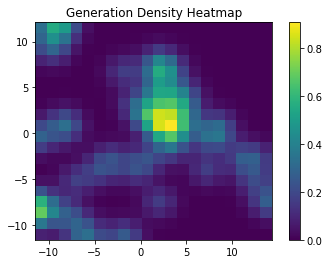

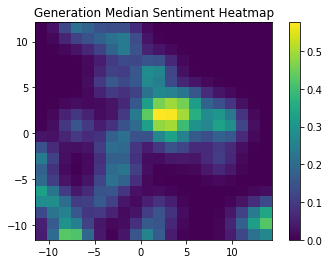

In [129]:
#scatterplot
principalComponents = pca.fit_transform(np.array(embed_2))
embed_2 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
embed_2["responses"] = embed_2_responses
fig = px.scatter(embed_1, x="pc1", y="pc2", opacity=.4, hover_name="responses")
fig.show()

#heatmap with raw numbers 
heatmap2, xedges, yedges = np.histogram2d(list(embed_2["pc1"]), list(embed_2["pc2"]), bins=bin_size, density=False)
heatmap2 = gaussian_filter(heatmap2, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap2.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights
# heatmap, xedges, yedges = np.histogram2d(list(embed_2["pc1"]), list(embed_2["pc2"]), bins=bin_size, weights = embed_2_weights, density=True)
# # average = heatmap / np.sum(heatmap)
# heatmap = gaussian_filter(heatmap, sigma=1)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()


#median sentiment heatmap
# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_2["pc1"]), list(embed_2["pc2"]), embed_2_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()

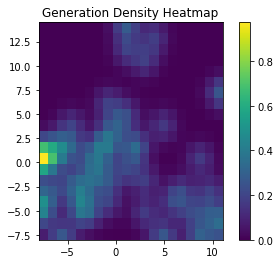

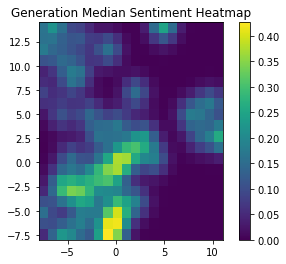

In [130]:
#scatterplot
principalComponents = pca.fit_transform(np.array(embed_3))
embed_3 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
embed_3["responses"] = embed_3_responses
fig = px.scatter(embed_1, x="pc1", y="pc2", opacity=.4, hover_name="responses")
fig.show()

#heatmap with raw numbers
heatmap3, xedges, yedges = np.histogram2d(list(embed_3["pc1"]), list(embed_3["pc2"]), bins=bin_size)
heatmap3 = gaussian_filter(heatmap3, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap3.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights
# heatmap, xedges, yedges = np.histogram2d(list(embed_3["pc1"]), list(embed_3["pc2"]), bins=bin_size, weights = embed_3_weights, density=False)
# heatmap = gaussian_filter(heatmap, sigma=1)
# # print(heatmap)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()

#median sentiment heatmap
# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_3["pc1"]), list(embed_3["pc2"]), embed_3_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()


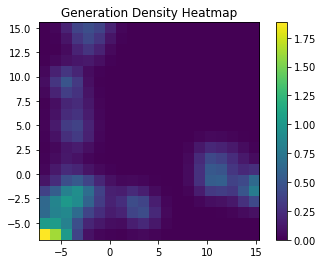

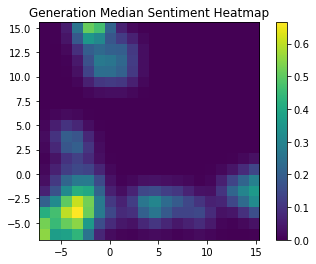

In [131]:
#scatterplot
principalComponents = pca.fit_transform(np.array(embed_4))
embed_4 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
embed_4["responses"] = embed_4_responses
fig = px.scatter(embed_4, x="pc1", y="pc2", opacity=.4, hover_name="responses")
fig.show()

#heatmap with raw numbers
heatmap4, xedges, yedges = np.histogram2d(list(embed_4["pc1"]), list(embed_4["pc2"]), bins=bin_size)
heatmap4 = gaussian_filter(heatmap4, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap4.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights
# heatmap, xedges, yedges = np.histogram2d(list(embed_4["pc1"]), list(embed_4["pc2"]), bins=bin_size, weights = embed_4_weights, density=False)
# heatmap = gaussian_filter(heatmap, sigma=1)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()

#median sentiment heatmap
# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_4["pc1"]), list(embed_4["pc2"]), embed_4_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()

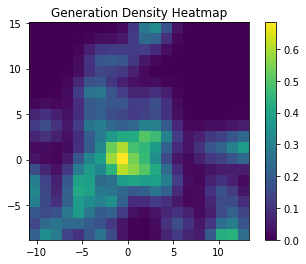

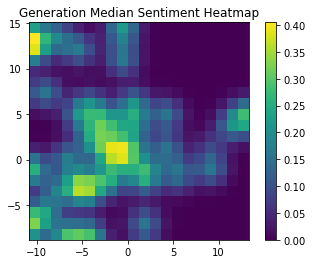

In [132]:
#scatterplot
principalComponents = pca.fit_transform(np.array(embed_5))
embed_5 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
embed_5["responses"] = embed_5_responses
fig = px.scatter(embed_5, x="pc1", y="pc2", opacity=.4, hover_name="responses")
fig.show()

#heatmap
heatmap5, xedges, yedges = np.histogram2d(list(embed_5["pc1"]), list(embed_5["pc2"]), bins=bin_size)
heatmap5 = gaussian_filter(heatmap5, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap5.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights
# heatmap, xedges, yedges = np.histogram2d(list(embed_5["pc1"]), list(embed_5["pc2"]), bins=bin_size, weights = embed_5_weights, density=False)
# heatmap = gaussian_filter(heatmap, sigma=1)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()

#median sentiment heatmap
# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_5["pc1"]), list(embed_5["pc2"]), embed_5_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()

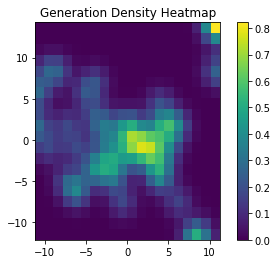

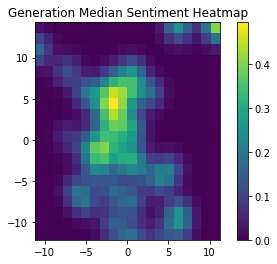

In [133]:
#scatterplot
principalComponents = pca.fit_transform(np.array(embed_6))
embed_6 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
embed_6["responses"] = embed_6_responses
fig = px.scatter(embed_6, x="pc1", y="pc2", opacity=.4, hover_name="responses")
fig.show()

#heatmap
heatmap6, xedges, yedges = np.histogram2d(list(embed_6["pc1"]), list(embed_6["pc2"]), bins=bin_size)
heatmap6 = gaussian_filter(heatmap6, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap6.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights
# heatmap, xedges, yedges = np.histogram2d(list(embed_6["pc1"]), list(embed_6["pc2"]), bins=bin_size, weights = embed_6_weights, density=False)
# heatmap = gaussian_filter(heatmap, sigma=1)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()

#median sentiment heatmap
# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_6["pc1"]), list(embed_6["pc2"]), embed_6_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()

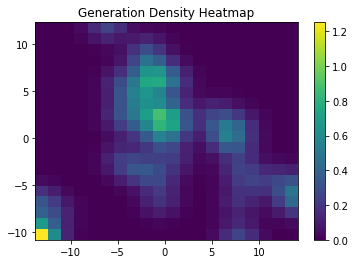

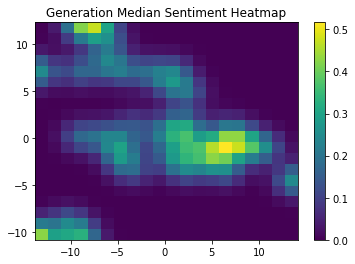

In [134]:
#scatterplot
principalComponents = pca.fit_transform(np.array(embed_7))
embed_7 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
embed_7["responses"] = embed_7_responses
fig = px.scatter(embed_7, x="pc1", y="pc2", opacity=.4, hover_name="responses")
fig.show()

#heatmap
heatmap7, xedges, yedges = np.histogram2d(list(embed_7["pc1"]), list(embed_7["pc2"]), bins=bin_size)
heatmap7 = gaussian_filter(heatmap7, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap7.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights
# heatmap, xedges, yedges = np.histogram2d(list(embed_6["pc1"]), list(embed_6["pc2"]), bins=bin_size, weights = embed_6_weights, density=False)
# heatmap = gaussian_filter(heatmap, sigma=1)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()

#median sentiment heatmap
# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_7["pc1"]), list(embed_7["pc2"]), embed_7_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()

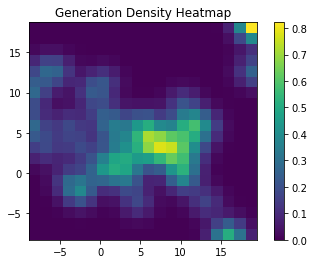

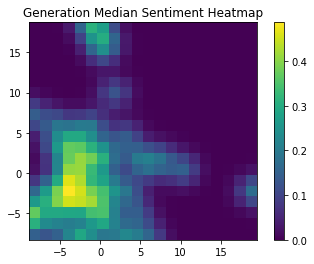

In [135]:
#scatterplot
principalComponents = pca.fit_transform(np.array(embed_8))
embed_8 = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
embed_8["responses"] = embed_8_responses
fig = px.scatter(embed_8, x="pc1", y="pc2", opacity=.4, hover_name="responses")
fig.show()

#heatmap
heatmap8, xedges, yedges = np.histogram2d(list(embed_8["pc1"]), list(embed_8["pc2"]), bins=bin_size)
heatmap8 = gaussian_filter(heatmap6, sigma=1)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.title("Generation Density Heatmap")
plt.imshow(heatmap6.T, extent=extent, origin='lower')
plt.colorbar()
plt.show()

# #heatmap with weights
# heatmap, xedges, yedges = np.histogram2d(list(embed_6["pc1"]), list(embed_6["pc2"]), bins=bin_size, weights = embed_6_weights, density=False)
# heatmap = gaussian_filter(heatmap, sigma=1)
# extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# plt.clf()
# plt.imshow(heatmap.T, extent=extent, origin='lower')
# plt.show()

#median sentiment heatmap
# Compute the median of the weights in each bin
median, _, _, _ = binned_statistic_2d(list(embed_8["pc1"]), list(embed_8["pc2"]), embed_8_weights, statistic='median', bins=(bin_size, bin_size))
#set all nans to 0
for y in range(len(median)): 
    for x in range(len(median[y])):
        if pd.isna(median[x][y]):
            median[x][y]  = 0
median = gaussian_filter(median, sigma=1)

# plot the heatmap
plt.clf()
plt.title("Generation Median Sentiment Heatmap")
plt.imshow(median, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], interpolation='nearest')
plt.colorbar()
plt.show()

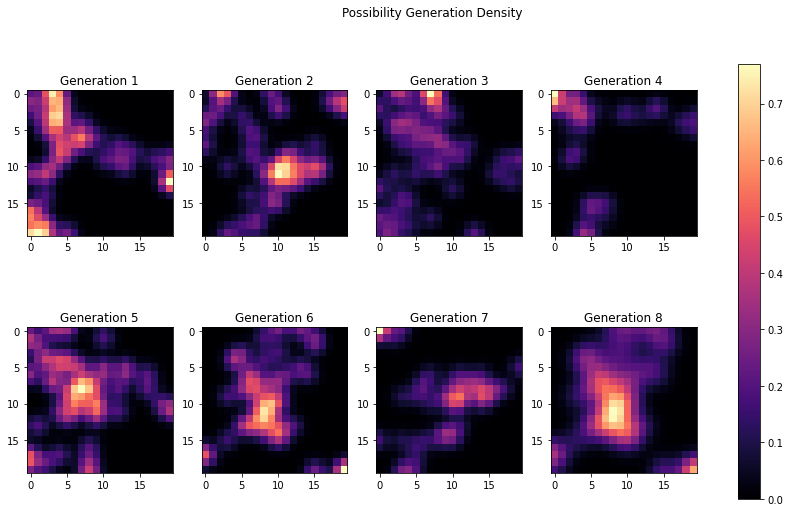

In [136]:
fig, axs = plt.subplots(2, 4, figsize=(15, 8))
# Create some data for the heatmaps

#r,c
# Create the heatmaps
im1 = axs[0][0].imshow(heatmap1, cmap='magma')
im2 = axs[0][1].imshow(heatmap2, cmap='magma')
im3 = axs[0][2].imshow(heatmap3, cmap='magma')
im4 = axs[0][3].imshow(heatmap4, cmap='magma')
im5 = axs[1][0].imshow(heatmap5, cmap='magma')
im6 = axs[1][1].imshow(heatmap6, cmap='magma')
im7 = axs[1][2].imshow(heatmap7, cmap='magma')
im8 = axs[1][3].imshow(heatmap8, cmap='magma')

# Create the colorbar and connect it to the heatmaps
cbar = fig.colorbar(im1, ax=axs)

#Add titles 
fig.suptitle("Possibility Generation Density")
axs[0][0].set_title("Generation 1")
axs[0][1].set_title("Generation 2")
axs[0][2].set_title("Generation 3")
axs[0][3].set_title("Generation 4")
axs[1][0].set_title("Generation 5")
axs[1][1].set_title("Generation 6")
axs[1][2].set_title("Generation 7")
axs[1][3].set_title("Generation 8")

# Adjust the layout
# fig.tight_layout()
plt.show()
